> <b>Predict A Doctor's Consultation Fee </b>



We have all been in situation where we go to a doctor in emergency and find that the consultation fees are too high. As a data scientist we all should do better. What if you have data that records important details about a doctor and you get to build a model to predict the doctor’s consulting fee.? This is the hackathon that lets you do that.

Dataset: https://github.com/dsrscientist/Data-Science-ML-Capstone-Projects/blob/master/Doctor_fee_consultation.zip

Size of training set: 5961 records

Size of test set: 1987 records

<b>FEATURES:</b>

<b>Qualification:</b> Qualification and degrees held by the doctor

<b>Experience:</b> Experience of the doctor in number of years

<b>Rating:</b> Rating given by patients

<b>Profile:</b> Type of the doctor

<b>Miscellaeous_Info:</b> Extra information about the doctor

<b>Fees:</b> Fees charged by the doctor

<b>Place:</b> Area and the city where the doctor is located.

<b>Importing Necessary Libraries</b>

In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
import missingno as msno 
from sklearn.model_selection import train_test_split
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
import nltk
nltk.download('stopwords')
import re
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from sklearn.ensemble import GradientBoostingRegressor

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
fee_train=pd.read_excel("Final_Train.xlsx")
fee_test=pd.read_excel("Final_Test.xlsx")

In [281]:
# Merging the datasets
fee=pd.concat([fee_train, fee_test],ignore_index=True)
fee.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
0,"BHMS, MD - Homeopathy",24 years experience,100%,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100.0
1,"BAMS, MD - Ayurveda Medicine",12 years experience,98%,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350.0
2,"MBBS, MS - Otorhinolaryngology",9 years experience,NaN,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300.0
3,"BSc - Zoology, BAMS",12 years experience,NaN,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250.0
4,BAMS,20 years experience,100%,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250.0


In [282]:
fee.shape

(7948, 7)

<b>Observation:</b>
There are 7948 rows and 7 columns in the dataset.

In [283]:
fee.dtypes

Qualification          object
Experience             object
Rating                 object
Place                  object
Profile                object
Miscellaneous_Info     object
Fees                  float64
dtype: object

<b>Observation:</b>
Out of 7 attributes, there are 6 attributes which are of object datatype and 1 attribute is of float datatype.

<b>Checking the Missing Values</b>

In [284]:
fee.isnull().sum()

Qualification            0
Experience               0
Rating                4392
Place                   31
Profile                  0
Miscellaneous_Info    3454
Fees                  1987
dtype: int64

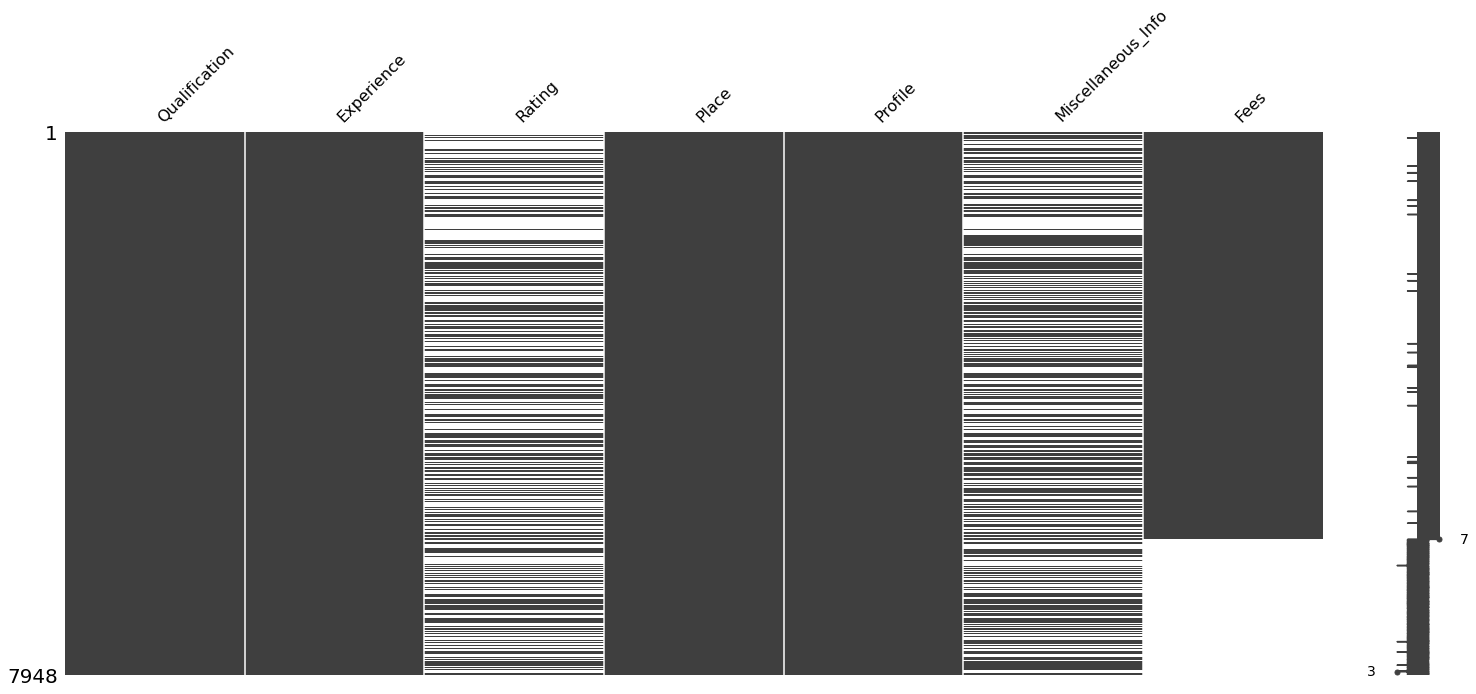

In [285]:
msno.matrix(fee) 
plt.show()

<b>Observation:</b>
We can see that there are missing values in the attributes (Fees,Miscellaneous_Info,Place,Rating).

In [0]:
# Filling the missing values attributes "Fees" using mean
fee['Fees'] = fee['Fees'].fillna(fee['Fees'].mean())

In [0]:
# Analysing the Rating column, it can be converted to int by stripping off Rating
fee["Rating"]= fee["Rating"].str.strip("%")
fee["Rating"].fillna(0,inplace=True)

In [0]:
# Converting attribute into int datatype
fee["Rating"]= fee["Rating"].astype(int)

In [0]:
# Analysing the Experience column, it can be converted to int by stripping off Experience
fee["Experience"]= fee["Experience"].str.strip("years experience")
# Converting attribute into int datatype
fee["Experience"]= fee["Experience"].astype(int)

In [290]:
# Lets check the value of Place
fee["Place"].value_counts()

HSR Layout, Bangalore         97
Andheri West, Mumbai          97
Dwarka, Delhi                 93
Banjara Hills, Hyderabad      85
Mulund West, Mumbai           81
                              ..
Jahangirpuri, Delhi            1
Safilguda, Hyderabad           1
Paravur, Ernakulam             1
Pasur-avanashi, Coimbatore     1
Kurla, Mumbai                  1
Name: Place, Length: 948, dtype: int64

In [0]:
#  We have taken 3 places where 
top_places= fee["Place"].value_counts().index[0:5]
null_condition=fee["Place"].isnull()

In [0]:
#We  will impute the null values with fisrt top 5 popular places where doctor sit
null_condition=fee[["Place"]].isnull()
count=0
for index_null in null_condition.index:
    if null_condition.loc[index_null][0]==True:
        if count%5==0:
            fee.loc[index_null,["Place"]]=top_places[0]
        if count%5==1:
            fee.loc[index_null,["Place"]]=top_places[1]
        if count%5==2:
            fee.loc[index_null,["Place"]]=top_places[2]
        if count%5==3:
            fee.loc[index_null,["Place"]]=top_places[3]
        if count%5==4:
            fee.loc[index_null,["Place"]]=top_places[4]
        count=count+1

In [293]:
#Now we will divide the Place column into multiple columns followed by finding maximum length in Place column
address_length=-1
for i in range(len(fee["Place"])):
    temp=len(fee["Place"].iloc[i].strip().upper().split(","))
    if temp>address_length:
        address_length=temp
print("Max address length is :{}".format(address_length))

Max address length is :3


In [0]:
P1=list()
P2=list()
P3=list()
for i in range(len(fee["Place"])):
    temp=fee["Place"].iloc[i].split(",")
    try :
        P1.append(temp[0].strip().upper())
    except :
        P1.append('NONE')
    try :
        P2.append(temp[1].strip().upper())
    except :
        P2.append('NONE')
    try :
        P3.append(temp[2].strip().upper())
    except :
        P3.append('NONE')

fee["P1"]=P1
fee["P2"]=P2
fee["P3"]=P3

In [295]:
fee.loc[fee["P3"]!="NONE"]

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,P1,P2,P3
2169,BDS,11,0,"Dwarka, Sector 5, Delhi",Dentist,NaN,250.0,DWARKA,SECTOR 5,DELHI


We see that there is one row where pr contains NaN.

In [0]:
# Now we are changing the p2 by p3 then drop p3 column
fee.loc[fee["P3"]!="NONE",["P2"]]= fee[["P3"]]
fee["P3"].fillna("DELHI",inplace=True)
# Dropping p3
fee.drop(["P3","Place"],axis=1,inplace=True)

In [297]:
#Now we are analysing the "Qualification" column and dividing it into multiple columns followed by maximum Length 
qualification_length=-1
for i in range(len(fee["Qualification"])):
    temp=len(fee["Qualification"].iloc[i].strip().upper().split(","))
    if temp>qualification_length:
        qualification_length=temp
print("Max qualification length is :{}".format(qualification_length))

Max qualification length is :17


In [0]:
Q1=list()
Q2=list()
Q3=list()
Q4=list()
Q5=list()
Q6=list()
Q7=list()
Q8=list()
Q9=list()
Q10=list()
Q11=list()
Q12=list()
Q13=list()
Q14=list()
Q15=list()
Q16=list()
Q17=list()
for i in range(len(fee["Qualification"])):
    temp=fee["Qualification"].iloc[i].split(",")
    try :
        Q1.append(temp[0].strip().upper())
    except :
        Q1.append('NONE')
    try :
        Q2.append(temp[1].strip().upper())
    except :
        Q2.append('NONE')
    try :
        Q3.append(temp[2].strip().upper())
    except :
        Q3.append('NONE')
    try :
        Q4.append(temp[3].strip().upper())
    except :
        Q4.append('NONE')
    try :
        Q5.append(temp[4].strip().upper())
    except :
        Q5.append('NONE')
    try :
        Q6.append(temp[5].strip().upper())
    except :
        Q6.append('NONE')
    try :
        Q7.append(temp[6].strip().upper())
    except :
        Q7.append('NONE')
    try :
        Q8.append(temp[7].strip().upper())
    except :
        Q8.append('NONE')
    try :
        Q9.append(temp[8].strip().upper())
    except :
        Q9.append('NONE')
    try :
        Q10.append(temp[9].strip().upper())
    except :
        Q10.append('NONE')
    try :
        Q11.append(temp[10].strip().upper())
    except :
        Q11.append('NONE')
    try :
        Q12.append(temp[11].strip().upper())
    except :
        Q12.append('NONE')
    try :
        Q13.append(temp[12].strip().upper())
    except :
        Q13.append('NONE')
    try :
        Q14.append(temp[13].strip().upper())
    except :
        Q14.append('NONE')
    try :
        Q15.append(temp[14].strip().upper())
    except :
        Q15.append('NONE')
    try :
        Q16.append(temp[15].strip().upper())
    except :
        Q16.append('NONE')
    try :
        Q17.append(temp[16].strip().upper())
    except :
        Q17.append('NONE')
        
        
fee["Q1"]=Q1
fee["Q2"]=Q2
fee["Q3"]=Q3
fee["Q4"]=Q4
fee["Q5"]=Q5
fee["Q6"]=Q6
fee["Q7"]=Q7
fee["Q8"]=Q8
fee["Q9"]=Q9
fee["Q10"]=Q10
fee["Q11"]=Q11
fee["Q12"]=Q12
fee["Q13"]=Q13
fee["Q14"]=Q14
fee["Q15"]=Q15
fee["Q16"]=Q16
fee["Q17"]=Q17

In [299]:
fee.loc[(fee["Q8"]!="NONE")|(fee["Q9"]!="NONE")|(fee["Q10"]!="NONE")|(fee["Q11"]!="NONE")|(fee["Q12"]!="NONE")|(fee["Q13"]!="NONE")|(fee["Q14"]!="NONE")|(fee["Q15"]!="NONE")|(fee["Q16"]!="NONE")|(fee["Q17"]!="NONE")]

,Qualification,Experience,Rating,Profile,Miscellaneous_Info,Fees,P1,P2,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17
1593,"Diploma in Diet and Nutrition, BHMS, Diploma i...",10,99,Homeopath,Dermabrasion Laser Resurfacing Acne / Pimples ...,500.00000,GHATKOPAR EAST,MUMBAI,DIPLOMA IN DIET AND NUTRITION,BHMS,DIPLOMA IN BEAUTY THERAPY,CERTIFICATE COURSE IN COSMETIC DERMATOLOGY & L...,PG DIPLOMA IN CLINICAL COSMETOLOGY (PGDCC),PG DIPLOMA IN TRICHOLOGY,CERTIFICATE IN BOTOX,FILLERS,THREADLIFTS,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
2035,"Fellowship in Oral implantlogy, Certified Adva...",22,97,Dentist,RCT - Root Canal Treatment Cosmetic/ Aesthetic...,300.00000,ASHOK NAGAR,CHENNAI,FELLOWSHIP IN ORAL IMPLANTLOGY,CERTIFIED ADVANCE COURSE IN ENDODONTICS,CERTIFIED IN ORTHODONTICS,CERTIFICATION IN FULL MOUTH REHABILITATION,CERTIFIED BPS DENTIST,CERTIFICATE IN COSMETIC DENTISTRY,PROFESSIONAL IMPLANTOLOGY TRAINING COURSE (PITC),FELLOWSHIP IN ADVANCED ENDOSCOPIC SINUS SURGERY,DEGREE IN DENTAL IMPLANT,FELLOWSHIP IN LASERS & COSMETOLOGY,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3562,"MBBS, Diploma in Family Medicine (DFM), Certif...",5,0,General Medicine,NaN,700.00000,COIMBATORE RACECOURSE,COIMBATORE,MBBS,DIPLOMA IN FAMILY MEDICINE (DFM),CERTIFICATE COURSE IN GESTATIONAL DIABETES (CC...,CCEDM,POST GRADUATE DIPLOMA IN DIABETOLOGY (PGDD)(CA...,UK),ACDMC,CCMTD,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3580,"MBBS, MD - General Medicine, Post Graduate Dip...",17,88,General Medicine,Non-Invasive Cardiology Chest Pain Treatment C...,100.00000,GREATER KAILASH PART 1,DELHI,MBBS,MD - GENERAL MEDICINE,POST GRADUATE DIPLOMA IN DIABETOLOGY (PGDD),FELLOWSHIP IN NON-INVASIVE CARDIOLOGY (FIC),ADVANCED CERTIFICATE COURSE IN DIABETES,ADVANCED CERTIFICATE COURSE IN DIABETES,ADVANCED CERTIFICATION IN CLINICAL DIABETOLOGY,POST GRADUATE CERTIFICATE IN SPORTS MEDICINE,CLINICAL CARDIOLOGY CERTIFICATION,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
4174,"MBBS, DNB - General Medicine, FRCP, Post Gradu...",29,76,General Medicine,"76% 8 Feedback Old Rajendra Nagar, Delhi",100.00000,OLD RAJENDRA NAGAR,DELHI,MBBS,DNB - GENERAL MEDICINE,FRCP,POST GRADUATE CERTIFICATE IN HIV AND STD MANEG...,FELLOWSHIP IN RHEUMATOLOGY,FELLOW INDIAN ACADEMY OF CLINICAL MEDICINE,ADVANCE COURSE IN OSTEOPOROSIS,EULAR CERTIFICATE FOR RHEUMATIC DISEASES,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
5667,"MD - CCM, MD - Physician, Post Graduate Diplom...",13,0,General Medicine,NaN,300.00000,PUNJAGUTTA,HYDERABAD,MD - CCM,MD - PHYSICIAN,POST GRADUATE DIPLOMA IN DIABETOLOGY (PGDD),CCST - DIABETES & ENDOCRINOLOGY,MASTER OF FAMILY MEDICINE,DIPLOMA IN FAMILY MEDICINE (DFM),POSTGRADUATE DIPLOMA CLINICAL CARDIOLOGY (PGDCC),POST GRADUATE DIPLOMA IN DIABETOLOGY (PGDD),MD - CARDIOLOGY,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
7248,"BDS, PG Diploma in Conservative, Endodontics a...",4,100,Dentist,Dental Crowns Dental Fillings Dental Implant F...,307.94464,NEW ASHOK NAGAR,DELHI,BDS,PG DIPLOMA IN CONSERVATIVE,ENDODONTICS AND AESTHETIC DENTISTRY,FELLOWSHIP IN CLINICAL COSMETOLOGY,PG DIPLOMA IN CLINICAL COSMETOLOGY (PGDCC),MBA - HOSPITAL MANAGEMENT,DIPLOMA IN COSMETIC DENTISTRY,FELLOW OF ACADEMY OF GENERAL EDUCATION (FAGE),ADVANCED RETREATMENT COURSE IN RCT,ADVANCED ENDOTONTIC COURSE ON ROOT CANAL,CERTIFIED COURSE IN ORAL SURGERY,MIDA,CERTIFICATION IN PROSTHODONTICS & PERIODONTOLOGY,CERTIFIED ADVANCED COURSE IN WISDOM TOOTH EXTR...,CERTIFICATE IN COSMETIC DENTISTRY,FELLOWSHIP IN AESTHETIC DENTISTRY (FAD),POST GRADUATE CERTIFICATE IN ENDODONTICS (PGCE)
7249,"FAMS - Fellowship of the Academy Medicine, MBB...",28,60,ENT Specialist,"60% 1 Feedback AS Rao Nagar, Hyderabad",307.94464,AS RAO NAGAR,HYDERABAD,FAMS - FELLOWSHIP OF THE ACADEMY MEDICINE,MBBS,MS - ENT,DIPLOMA IN ENT,SPECIALIZED TRAINING IN OTOLOGY,FELLOWSHIP IN HEAD & NECK ONCOLOGY SURGERY,ADVANCED ENDOSCOPY TRAINING,COCHLEAR IMPLANT SURGERY,ADVANCE COURSE ON DIAGNOSIS OF ALLERGY AND IMM...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [0]:
# dropping columns
fee.drop(["Q8","Q9","Q10","Q11","Q12","Q13","Q14","Q15","Q16","Q17","Qualification"],axis=1,inplace=True)

In [0]:
#Below function we will use to clean the Miscellaneous_Info column
stop_words=list(stopwords.words('english'))
lemmatizer = WordNetLemmatizer() 
def clean(text):
    newstring=""
    text=re.sub("[\W*]"," ",text)
    text=re.sub("\d+[a-z]*"," ",text)
    text=re.sub("\s+"," ",text)
    count=0
    for word in text.split():
        if word not in stop_words:
            word=lemmatizer.lemmatize(word)
            if count==0:
                newstring=newstring+word
            if count!=0:
                newstring=newstring+" "+word
            count=count+1
    return newstring

In [0]:
fee["Miscellaneous_Info"]=fee["Miscellaneous_Info"].astype(str)

In [0]:
fee["Miscellaneous_Info"]=fee["Miscellaneous_Info"].apply(lambda x: clean(x))

In [0]:
#Lets use tf-idf to convert Miscellaneous_Info
vc = TfidfVectorizer(max_features=1000)
fee_data= vc.fit_transform(fee["Miscellaneous_Info"].to_list())

In [0]:
fee=pd.concat([fee,pd.DataFrame(fee_data.toarray())],axis=1)
fee.drop(["Miscellaneous_Info"],axis=1,inplace=True)

<b>Exploratory Data Analysis</b>

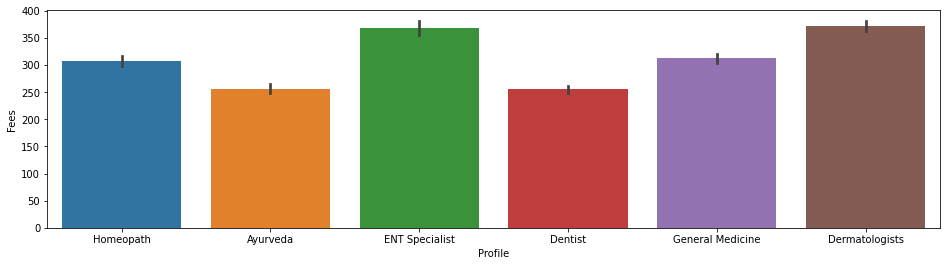

In [306]:
import seaborn as sns
plt.figure(figsize=(16,4))
sns.barplot(x="Profile",y="Fees",data=fee)
plt.show()

<b>Observation:</b>
From the above visualization, we see that most of the Doctors are ENT Specialist.

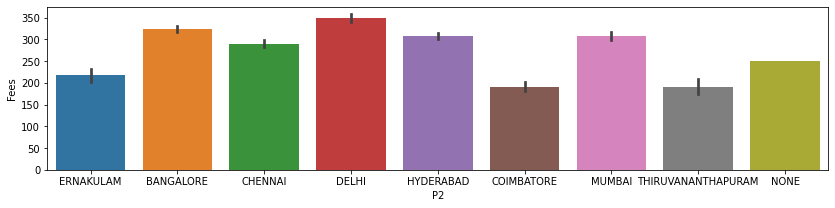

In [308]:
plt.figure(figsize=(14,3))
sns.barplot(x="P2",y="Fees",data=fee)
plt.show()

<b>Observation:</b>
From the above visualization, we see that most of the doctors are from Delhi.

In [0]:
fee["Profile"]=pd.to_numeric(fee["Profile"],errors='coerce')
fee["P1"]=pd.to_numeric(fee["P1"],errors='coerce')
fee["P2"]=pd.to_numeric(fee["P2"],errors='coerce')
fee["Q1"]=pd.to_numeric(fee["Q1"],errors='coerce')
fee["Q2"]=pd.to_numeric(fee["Q2"],errors='coerce')

<b>Label Encoder</b>

In [0]:
from sklearn.preprocessing import LabelEncoder
# Converting the categorical variables 
l=LabelEncoder()
# Converting the categorical variables 
for col in fee.columns:
    if fee[col].dtype=="object":
        fee[col]=LabelEncoder().fit_transform(fee[col])

<b>Dividing the data into train and test</b>

In [0]:
#Lets seprate the input and output from train dataset
X=fee.drop(columns=["Fees"],axis=1)
y=fee[["Fees"]]

In [0]:
# Lets bring the dataset features into same scle
from sklearn.preprocessing import StandardScaler
sr=StandardScaler()
X=sr.fit_transform(X)

In [0]:
# Replacing NaN with zero
X[:]= np.nan_to_num(X)
y[:]=np.nan_to_num(y)

<b>Splitting the data into train and test</b>

In [0]:
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.3)

In [0]:
# We are using R2 score to evaluate
def r2_score(models,X,y):
    r2_score=0
    for r_state in range(42,100):
        X_train,X_test, y_train, y_test= train_test_split(X,y,test_size=0.30, random_state=r_state)
        models.fit(X_train,y_train)
        y_pred= models.predict(X_test)
        score=r2_score(y_test,y_pred)
        if score>r2_score:
            r2_score=score
            final_r2_score=r_state
    print("Maximum R2_Score corresponding:",final_r2_score," and it is :",round((r2_score),2))

# Machine Learning Models:

As the target variable is continuous, its a regression problem. We are implementing Gradient Boosting Regressor, KNN Regressor, XG Boost Regressor and Random Forest Regressor.

<b>Gradient Boosting Regressor</b>

In [228]:
gb1 = GradientBoostingRegressor()
parameters= {'learning_rate': [0.02,0.03], 'subsample': [0.5,0.7], 'n_estimators': [50,100], 'max_depth': [6,10]}
gb1= GridSearchCV(estimator=gb1, param_grid= parameters, cv=5, n_jobs=-1)
gb1.fit(X,y)
gb1.best_params_

{'learning_rate': 0.02, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.5}

In [0]:
gb1 = GradientBoostingRegressor(learning_rate=0.02,max_depth=6,n_estimators=50,subsample=0.5)

In [0]:
pred_gb1= gb1.predict(X_test)
score_gb1= gb1.score(X_test, y_test)

In [246]:
print("R-Square:",metrics.r2_score(y_test,pred_gb1))
gb_r=metrics.r2_score(y_test,pred_gb1)

R-Square: 0.14830975425124826


In [241]:
# Cross validation score
mean_gb1=cross_val_score(gb1,X,y,cv=10,scoring="r2").mean()
print("Mean R2 Score for Gradient Boosting Regressor:",mean_gb1)
std_gb1=cross_val_score(gb1,X,y,cv=10,scoring="r2").std()
print("Standard Deviation in R2 Score for Gradient Boosting Regression:",std_gb1)

Mean R2 Score for Gradient Boosting Regressor: -1.0251171769684465e+29
Standard Deviation in R2 Score for Gradient Boosting Regression: 2.0821289610741226e+29


In [242]:
# RMSE
from sklearn import metrics
gb1_rmse=np.sqrt(metrics.mean_squared_error(y_test,pred_gb1))
gb1_rmse

150.47519782328143

<b>KNN Regressor</b>

In [243]:
from sklearn.neighbors import KNeighborsRegressor
knn1=KNeighborsRegressor()
parameters={"n_neighbors":range(2,30)}
knn1= GridSearchCV(knn1,parameters,cv=5)
knn1.fit(X,y)
knn1.best_params_

{'n_neighbors': 29}

In [253]:
knn1= KNeighborsRegressor(n_neighbors=29)
knn1.fit(X,y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=29, p=2,
                    weights='uniform')

In [0]:
pred_knn1= knn1.predict(X_test)

In [255]:
print("R-Square:",metrics.r2_score(y_test,pred_knn1))
knn_r=metrics.r2_score(y_test,pred_knn1)

R-Square: 0.16010707940801183


In [256]:
# Cross validation score
mean_knn1=cross_val_score(knn1,X,y,cv=10,scoring="r2").mean()
print("Mean R2 Score for KNN Regressor:",mean_knn1)
std_knn1=cross_val_score(knn1,X,y,cv=10,scoring="r2").std()
print("Standard Deviation in R2 Score for KNN Regressor:",std_knn1)

Mean R2 Score for KNN Regressor: -2.6940541137010657e+29
Standard Deviation in R2 Score for KNN Regressor: 5.388244719570267e+29


In [257]:
knn_rmse=np.sqrt(metrics.mean_squared_error(y_test,pred_knn1))
knn_rmse

149.42939791081437

<b>Random Forest Regressor</b>

In [263]:
rf1=RandomForestRegressor()
param_grid = {
    'max_depth': [80, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 5],
    'min_samples_split': [10, 12],
    'n_estimators': [100, 500]
}
rf1= GridSearchCV(rf1, param_grid,cv=5)
rf1.fit(X,y)
rf1.best_params_

{'max_depth': 100,
 'max_features': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 500}

In [265]:
rf1=RandomForestRegressor(max_depth=100,max_features=2,min_samples_leaf=5,min_samples_split=10,n_estimators=500)
rf1.fit(X,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
pred_rf1= rf1.predict(X_test)
score_rf1= rf1.score(X_test, y_test)

In [267]:
# Cross validation score
mean_rf1=cross_val_score(rf1,X,y,cv=10,scoring="r2").mean()
print("Mean R2 Score for Random Forest Regressor:",mean_rf1)
std_rf1=cross_val_score(rf1,X,y,cv=10,scoring="r2").std()
print("Standard Deviation in R2 Score for Random Forest Regression:",std_rf1)

Mean R2 Score for Random Forest Regressor: -1.126101301324264e+26
Standard Deviation in R2 Score for Random Forest Regression: 2.0064662331965e+26


In [268]:
# RMSE
rf_rmse=np.sqrt(metrics.mean_squared_error(y_test,pred_rf1))
rf_rmse

162.6328136403622

# Evaluation:

In [272]:
#Lets initialise the data frame with columns model and f1_score
models= [["Gradient Boosting Regressor",gb1_rmse],["KNN Regressor",knn_rmse],["Random Forest Regressor",rf_rmse]]
comparsion_data= pd.DataFrame(models, columns=["Model Name","RMSE"], index=[1,2,3])
comparsion_data

,Model Name,RMSE
1,Gradient Boosting Regressor,150.475198
2,KNN Regressor,149.429398
3,Random Forest Regressor,162.632814


From the above comparsion, KNN Regressor performed well with lowest RMSE of 149.429398.

<b>Saving the Prediction</b>

As the KNN Regressor performed well, we are saving the prediction.

In [0]:
np.savetxt('Model18.csv',pred_knn1,delimiter=',')

In [274]:
#Lets save the above model
from sklearn.externals import joblib 
  
# Save the model as a pickle in a file 
joblib.dump(knn1, 'project18.pkl')

['project18.pkl']